---
title: Rabbits Islands - Full API
---

{{< include _intro.qmd >}}

In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
import pandas as pd
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
import seaborn as sns
from ptdalgorithms import Graph, set_theme
%config InlineBackend.figure_format = 'retina'
# plt.style.use('dark_background')
# import matplotlib
# matplotlib.rcParams['axes.facecolor'] = '#1F1F1F'
# matplotlib.rcParams['figure.facecolor'] = '#1F1F1F'

#plt.rcParams.update({'figure.facecolor': '#1F1F1F', 'axes.facecolor': '#1F1F1F'})
set_theme('light')

# State-space construction

In [3]:
def c(*args):
    elem = []
    for arg in args:
        if hasattr(arg, '__len__') and len(arg) > 1:
            elem.extend(arg)
        else:
            elem.append(arg)
    return np.array(elem)

In [4]:
def print_states(vertex):
    print(vertex.state())
    for edge in vertex.edges():
        print(" ", edge.weight() , "->", edge.to().state())    

This phase-type distribution models the time until all rabits have died We can find the expectation, variance, moments

In [5]:
def construct_rabbit_graph(nr_rabbits, flood_left, flood_right):
    
    # we represent the vector as two integers, the number of 
    # rabbits on the left and right island
    state_vector_length = 2
    graph = Graph(state_vector_length)
    
    # the initial state is the only starting state, with probability 1
    initial_state = [nr_rabbits, 0]
    vertex = graph.find_or_create_vertex(initial_state)
    graph.starting_vertex().add_edge(vertex, 1)
    
    index = 1
    # iterate over all unvisited vertices
    while index < graph.vertices_length():
        vertex = graph.vertex_at(index)
        state = vertex.state()
        
        if state[0] > 0:
            # rabbit jump left to right
            child_state = [state[0] - 1, state[1] + 1]
            vertex.add_edge(
                graph.find_or_create_vertex(child_state),
                weight=1
            )
            # left island flooding
            child_state = [0, state[1]]
            vertex.add_edge(
                graph.find_or_create_vertex(child_state), 
                weight=flood_left
            )
        if state[1] > 0:   
            child_state = [state[0] + 1, state[1] - 1]
            vertex.add_edge(
                graph.find_or_create_vertex(child_state),
                weight=1
            )
            # right island flooding
            child_state = [state[0], 0]
            vertex.add_edge(
                graph.find_or_create_vertex(child_state), 
                weight=flood_right
            )
    
        index += 1
    return graph

In [6]:
graph = construct_rabbit_graph(2, 2, 4)        
graph.states()

array([[0, 0],
       [2, 0],
       [1, 1],
       [0, 0],
       [0, 2],
       [0, 1],
       [1, 0]], dtype=int32)

You can plot the graph for visual inspection:

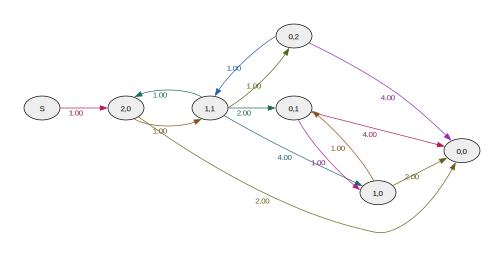

In [7]:
graph.plot()

and group, states by some property, by supplying a lambda function for the `subgraphfun` keyword argument:

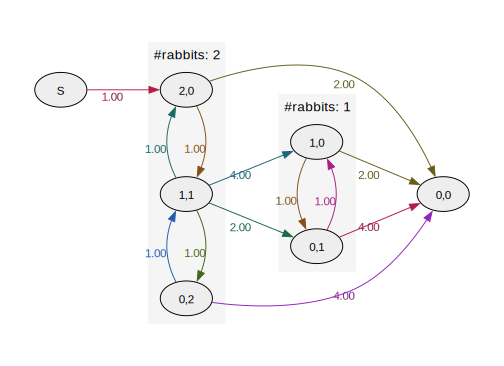

In [8]:
graph.plot(subgraphfun=lambda state: f"#rabbits: {sum(state)}")

In an abbreviated version using the aliases `ae` and `focv` for `add_edge` and `find_and_create_vertex`

In [9]:
nr_rabbits, flood_left, flood_right = 2, 2, 4

graph = Graph(2)
graph.starting_vertex().add_edge(graph.focv(c(nr_rabbits, 0)), 1)
i = 1
while i < graph.vertices_length():
    v = graph.vertex_at(i)
    st = v.state()
    if st[0] > 0:
        v.ae(graph.focv([st[0]-1, st[1]+1]), 1)
        v.ae(graph.focv([0, st[1]]), flood_left)
    if st[1] > 0:   
        v.ae(graph.focv([st[0]+1, st[1]-1]), 1)
        v.ae(graph.focv([st[0], 0]), flood_right)
    i += 1
    
#graph.states()

You can skip some of the boilerplate code by passing a callback function and an initial state to `Graph`. The call back function has the signature `callback(List[int]) -> List[Dict]`. It takes a list argument specifying a state and returns a list of dictionaries each specifying a child state and an edge weight: `{'state': [0, 1], 'weight': 0.4}`. This approach is slower and is intended mainly for speed up model development and exploration, and to reduce the amount of code needed to represent many models.

To create a callback function, just think of rules of your model and ask yourself: "Given some state, what are the allowed transitions to other states and with what rates to these transititons occur?". Make a small dictionary for each such transition with the child state and rate (weight) and return them as a list. Here is an example. If the current state is "two rabbits on the left island" (`[2, 0]`), the reachable states are: "one rabbit on each island" (`[1, 1]`) if one rabbit jumps and and "no rabbits" (`[0, 0]`) if the island is flodded. The callback function should in that case produce the mapping:

```python
[2, 0] -> [{'state': [1, 1], 'weight': 1, }, {'state': [0, 0], 'weight': flood_left}]
```

Here is what the callback function looks like for the rabbit model:

In [10]:
def rabbit_islands(state):
    children = []
    if state[0] > 0:
        children.append({'state': [state[0]-1, state[1]+1], 'weight': 1})
        children.append({'state': [0,          state[1]  ], 'weight': flood_left})
    if state[1] > 0:   
        children.append({'state': [state[0]+1, state[1]-1], 'weight': 1})
        children.append({'state': [state[0],   0         ], 'weight': flood_right})
    return children

initial_state = [nr_rabbits, 0]    

Notice that the usual scoping rules apply to the callback functions: the variables defined outside the function `flood_left` and `flood_right` are accessible to the function as for any Python function.

## Matrix interface

To allow imbedding in a matrix based workflow, a matrix-based representation of the phase-type distribution can be extracted from the graph. Note that the indices in the matrix representation do not correspond to vertex indices in the graph.

In [11]:
mats = graph.as_matrices()
print("Initial probability vector:")
print(mats.ipv)
print("Subintensity matrix:")
print(mats.sim)
print("States:")
print(mats.states)
print("Indicies:")
print(mats.indices)


Initial probability vector:
[0. 0. 1. 0. 0.]
Subintensity matrix:
[[-5.  1.  0.  0.  0.]
 [ 1. -8.  1.  4.  2.]
 [ 0.  1. -3.  0.  0.]
 [ 0.  0.  0. -3.  1.]
 [ 0.  0.  0.  1. -5.]]
States:
[[0 2]
 [1 1]
 [2 0]
 [1 0]
 [0 1]]
Indicies:
[5 3 2 7 6]


Although computationally inefficient, the graph can also be constructed from an initial probability vector and a subintensity matrix:

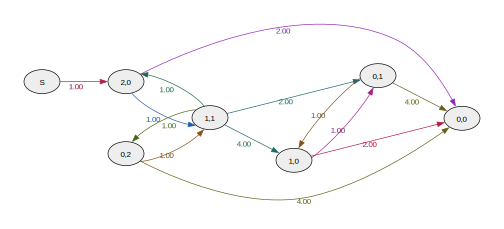

In [12]:
graph = Graph.from_matrices(mats.ipv, mats.sim, mats.states)
graph.plot()

If the state argument is not provided, matrix indices are used as matrix states:

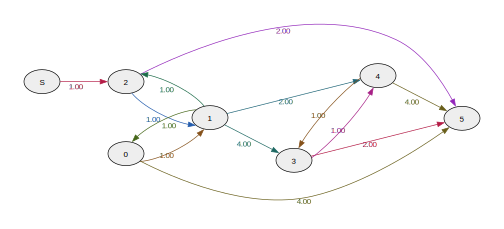

In [13]:
graph = Graph.from_matrices(mats.ipv, mats.sim)
graph.plot()

## Continuous phase-type distribution

We can now construct the graphs by the function. The flooding rates are set to 2 and 4

In [14]:
graph = construct_rabbit_graph(2, 2, 4)

Get the number of vertices in the graph:

In [15]:
graph.vertices_length()

7

as well as integer vector states that those vertices represent:

In [16]:
M = graph.states()
M

array([[0, 0],
       [2, 0],
       [1, 1],
       [0, 0],
       [0, 2],
       [0, 1],
       [1, 0]], dtype=int32)

(or nicely as a dataframe):

In [17]:
pd.DataFrame(M, columns=["Rabbits left", "Rabbits right"])#.style.hide()

,Rabbits left,Rabbits right
0,0,0
1,2,0
2,1,1
3,0,0
4,0,2
5,0,1
6,1,0


This phase-type distribution models the time until all rabits have died. For convenience, we can get its expectation and variance like this:

In [18]:
graph.expectation()

INFO: building reward compute graph...


0.5038265306122448

In [19]:
graph.variance()

0.2264567497917534

But if you want you can get any number of moments like this (here three):

In [20]:
graph.moments(3)

[0.5038265306122448, 0.48029792274052463, 0.6559101757731152]

We can find the expected waiting time given that we start in any of the states, not just the starting state:        

In [21]:
graph.expected_waiting_time()

[0.5038265306122448,
 0.5038265306122448,
 0.5114795918367346,
 0.0,
 0.30229591836734687,
 0.28571428571428564,
 0.4285714285714285]

We can get the CDF and PDF. The distribution methods reuse cached computations and recompute only if the graph changes. Compare the running times for the first and second call to the function:

In [22]:
time = np.arange(0, 4, 0.001)

In [23]:
%%time
cdf = graph.cdf(time)

CPU times: user 370 μs, sys: 28 μs, total: 398 μs
Wall time: 400 μs


In [24]:
%%time
cdf = graph.cdf(time)

CPU times: user 46 μs, sys: 17 μs, total: 63 μs
Wall time: 62 μs


In [25]:
%%time
pdf = graph.pdf(time)

CPU times: user 46 μs, sys: 19 μs, total: 65 μs
Wall time: 61 μs


PDF and CDF of distribution. Observe the long tails!

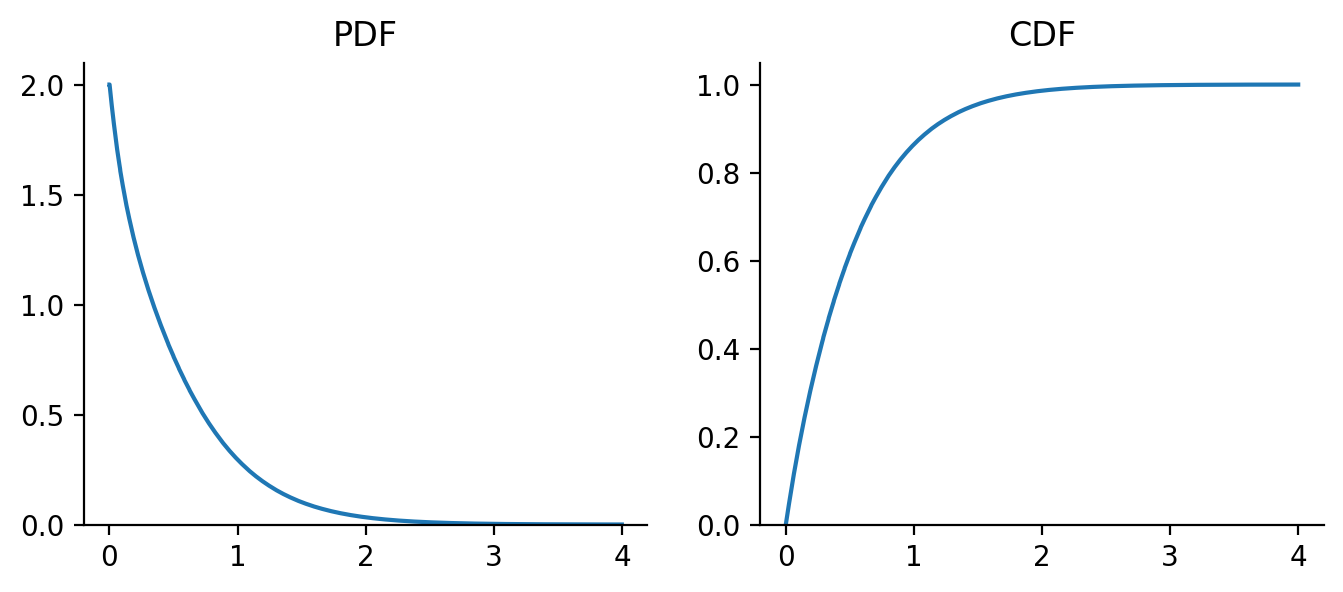

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
ax1.plot(time, pdf)
ax1.set_title("PDF")
ax1.set_ylim(bottom=0)
ax2.plot(time, cdf)
ax2.set_title("CDF")
ax2.set_ylim(bottom=0)
sns.despine()


## Rewards

We can add rewards which are based on the number of rabbits on the second island.

In [27]:
rewards = graph.states()[:, 1]

Can also be computed like this:

In [28]:
rewards = np.array([graph.vertex_at(i).state()[1] for i in range(graph.vertices_length())])

Adding these rewards, the phase-type distribution now represent the total accumulated time that any rabbits spends on the right island.

Using rewards to the moment functions etc. is much faster than changing the graph.

The expectation and variance are now:

In [29]:
graph.expectation(rewards), graph.variance(rewards)

(0.09438775510204081, 0.04634787588504788)

Using rewards to the moment functions etc. is much faster than actually changing the graph, but sometimes we might want to be interested in reward transforming the phase-type distribution, giving us the full distribution of accumulated rewards. For example if we want the pdf/cdf.

In [30]:
right_graph = graph.reward_transform(rewards)

Now we get the expectation and variance from before without adding any rewards:

In [31]:
right_graph.expectation(), right_graph.variance()

INFO: building reward compute graph...


(0.09438775510204078, 0.046347875885047865)

We can find the distribution function for the the total accumulate time spent by any rabbit on an island. We show here the PDF and CDF

In [32]:
accumulated_rewards = np.arange(0, 2, 0.01)

pdf = right_graph.pdf(accumulated_rewards)
cdf = right_graph.cdf(accumulated_rewards)

PDF and CDF of distribution. Notice how we have a "defect" i.e. a probability of obtaining no rewards:

In [33]:
right_graph.defect()

0.6666666666666666

The defect is shown with a dotted line below. Remember to always consider this defect.

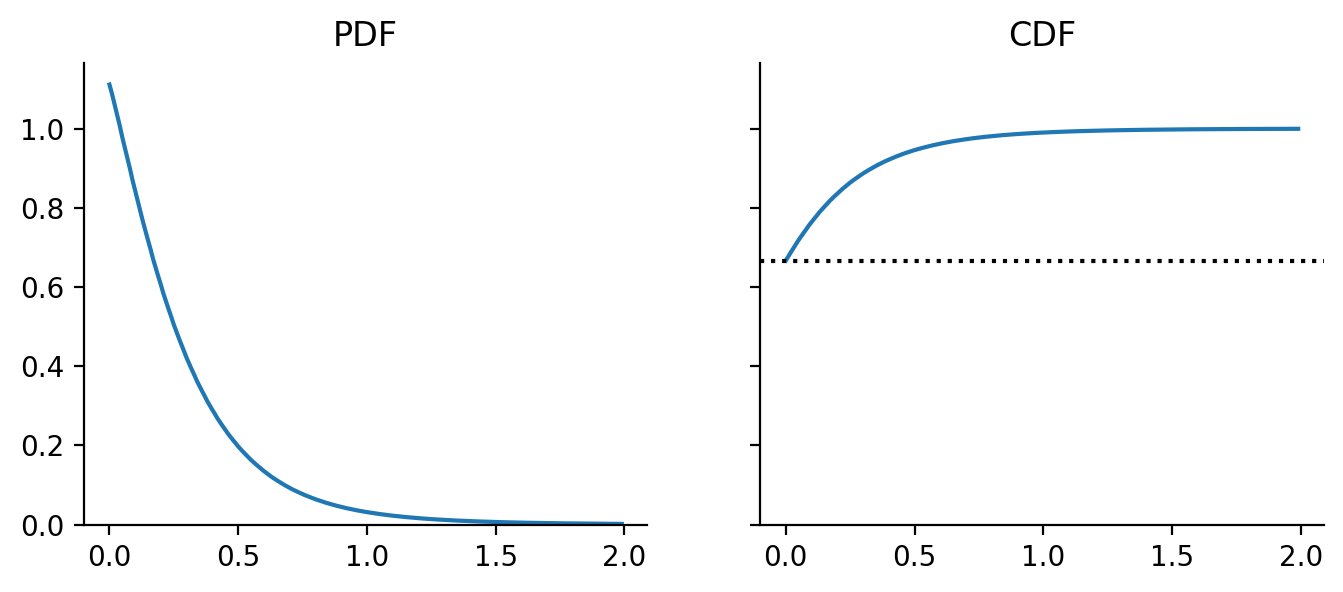

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
ax1.plot(accumulated_rewards, pdf)
ax1.set_title("PDF")
ax1.set_ylim(bottom=0)
ax2.plot(accumulated_rewards, cdf)
ax2.set_title("CDF")
ax2.set_ylim(bottom=0)
ax2.axhline(y=right_graph.defect(), linestyle='dotted', color='black')
sns.despine()

There are also utility methods to get the stop probability i.e. probabilities of occupying each state at time t. 

In [35]:
graph.stop_probability(0.2)

[0.0,
 0.5561531639166896,
 0.07040541534825098,
 0.0,
 0.007095725804629082,
 0.016348108066650276,
 0.03374890558205247]

We can use that to compute the expected number of rabbits across time:

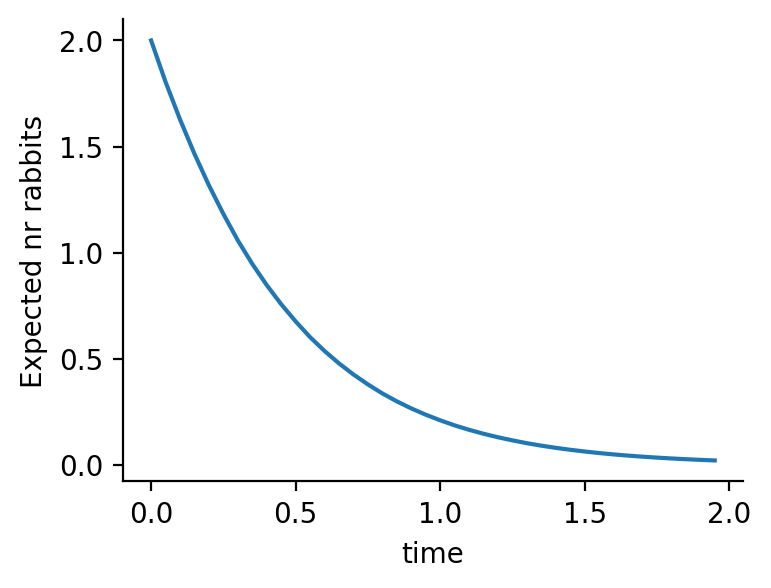

In [36]:
times = np.arange(0, 2, 0.05)
expected_rabbits_left = [
    np.sum(graph.stop_probability(i) 
           * np.sum(graph.states(), axis=1)) 
    for i in times
    ]

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(times, expected_rabbits_left)
ax.set_xlabel('time')
ax.set_ylabel("Expected nr rabbits")
sns.despine()


We can also get the accumulated visiting time of a particular state. E.g. the total time before time t=0.5 where there was a rabbit on the right island:

In [37]:
rewards = (graph.states()[:,1]>0).astype(int)
np.sum(graph.accumulated_visiting_time(time=0.5) * rewards)

np.float64(0.04053231796047568)

In [38]:
graph.expected_residence_time()

[0.0, 0.5038265306122448, 0.0, 0.0, 0.0, 0.0, 0.0]

# Random sampling

The library includes functions to do random sampling. These are useful to also validate the computations

In [39]:
graph.sample(5)

[0.10654450534134478,
 0.2096468961770757,
 0.15551459579961166,
 0.1302728624634086,
 0.008689251706179528]

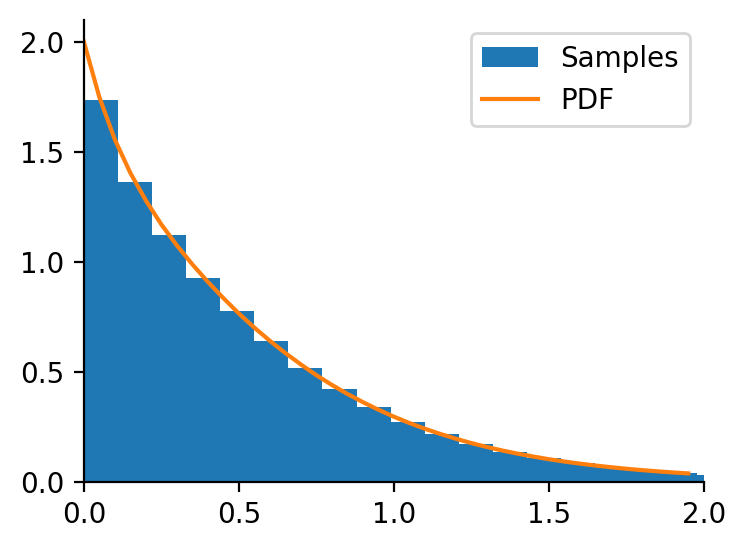

In [40]:
fig, ax = plt.subplots(figsize=(4, 3))
samples = graph.sample(1000000)

ax.hist(samples, bins=50, density=True, label='Samples')
x = np.arange(0, 2, 0.05)

ax.plot(x, [graph.pdf(t) for t in x], label='PDF')

ax.set_xlim(0, 2)
ax.legend()
sns.despine()

You can produce the moments from sampling if needed. Compare to the sampled and exact second moments:

In [41]:
np.sum(np.array(graph.sample(1000000))**2)/1000000, graph.moments(2)[1]

(np.float64(0.4802356496588736), 0.48029792274052463)

In [42]:
rewards = graph.states()[:,1]
np.sum(np.array(graph.sample(1000000, rewards))**2)/1000000, graph.moments(2, rewards)[1]

(np.float64(0.05480396506822537), 0.055256924198250706)

Reward-transforming first and then computing without rewards achieves the same thing:

In [43]:
revtr_graph = graph.reward_transform(rewards)
np.sum(np.array(revtr_graph.sample(1000000))**2)/1000000, revtr_graph.moments(2)[1]

INFO: building reward compute graph...


(np.float64(0.05577553177571136), 0.05525692419825069)

## Discrete phase-type distributions

We can also work with discrete phase-type distributions. This is the number of jumps in a Markov Chain before absorption. We will model that any rabbit can find a carrot at each time with rate 0.1 and see how many carrots the rabbits will have found. We could of course just make a new state-space creation function, but we can also manipulate existing.

In [44]:
carrot_graph = graph.copy()
vlength = carrot_graph.vertices_length()
carrot_vertices = np.repeat(False, vlength*2)


for i in range(vlength):
    vertex = carrot_graph.vertex_at(i)
    rabbits = sum(vertex.state())
    
    if rabbits > 0:
        obtained_carrot_vertex = carrot_graph.create_vertex([0])
        # Go directly back to the state we came from
        obtained_carrot_vertex.add_edge(vertex, 1)
        # Rate of finding carrot
        vertex.add_edge(obtained_carrot_vertex, rabbits * 0.1)
        carrot_vertices[obtained_carrot_vertex.index()] = True

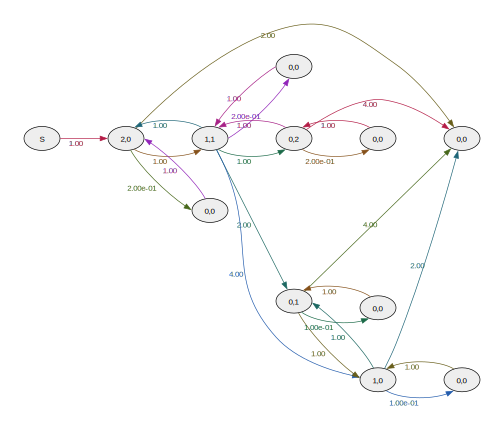

In [45]:
carrot_graph.plot()

In [46]:



vlength = carrot_graph.vertices_length()
carrot_vertices = np.repeat(False, vlength*2)

for i in range(vlength):
    vertex = carrot_graph.vertex_at(i)
    rabbits = sum(vertex.state())
    
    if rabbits > 0:
        obtained_carrot_vertex = carrot_graph.create_vertex([0])
        # Go directly back to the state we came from
        obtained_carrot_vertex.add_edge(vertex, 1)
        # Rate of finding carrot
        vertex.add_edge(obtained_carrot_vertex, rabbits * 0.1)
        carrot_vertices[obtained_carrot_vertex.index()] = True

carrot_vertices = carrot_vertices[np.arange(carrot_graph.vertices_length())]

# We now want to make the graph discrete. We do this by 'normalizing' the edges
# This is imply scaling the vertices such that the total out-going rate is 1
# As it is now the probability of transitions
weights_were_multiplied_with = carrot_graph.normalize()

print("This is the discrete state space as a sub-transition matrix:")
#carrot_graph.as_matrices()
print('GRAPH AS MATRIX MAKES THE KERNEL DIE...')

This is the discrete state space as a sub-transition matrix:
GRAPH AS MATRIX MAKES THE KERNEL DIE...


In [47]:
# for vertex in carrot_graph.vertices():
#     print(vertex.index(),vertex.state(), vertex.edges())

In [48]:
# for vertex in carrot_graph.vertices():
#     print(vertex)
#     for edge in vertex.edges():
#         print("  ", edge)

In [49]:
# carrot_vertices.astype(int)

We now want to find the expected number of eaten carrots. We set the reward such that the carrot vertex has a reward of '1'.


In [50]:
rewards = carrot_vertices.astype(int)
carrot_graph.expectation_discrete(rewards)

INFO: building reward compute graph...


0.09056122448979592

We can verify that the number of carrots correspond to scaling the continuous graph:

In [51]:
graph.expectation(graph.states().sum(axis=1)) * 0.1

0.09056122448979591

Of course we cannot do this for other moments:

In [52]:
carrot_graph.variance_discrete(rewards)

0.09723142700957937

Verified by sampling:

In [53]:
samples = carrot_graph.sample_discrete(1000000, rewards)
samples = np.array(samples)
np.sum(samples**2) / 1000000 - ((np.sum(samples)) / 1000000)**2

np.float64(0.096806053376)

In [54]:
# We can find the distribution function for the the total number of carrots found
carrots = np.arange(10)
# Notice that with this reward transformation the graph is no longer sparse, as all paths through
# the graph are represented!!
found_carrots_graph  = carrot_graph.reward_transform_discrete(rewards)
pmf = found_carrots_graph.pmf_discrete(carrots)
cdf = found_carrots_graph.cdf_discrete(carrots)


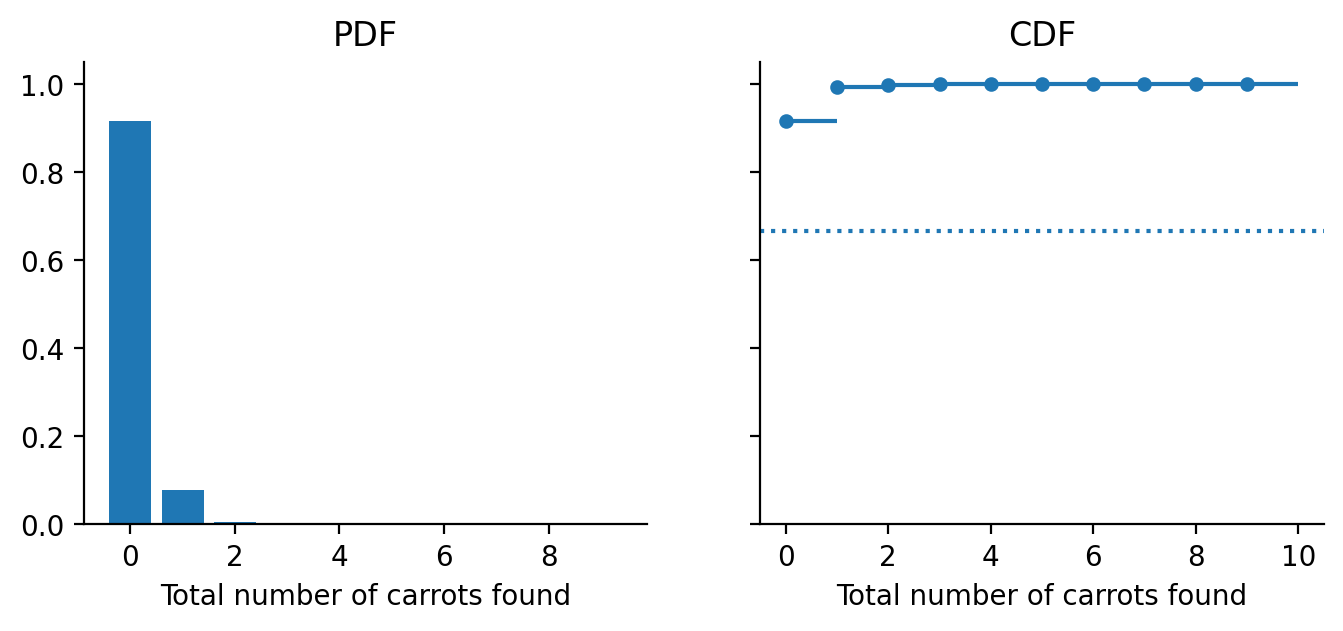

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
x = np.arange(0, 10, 1)
ax1.bar(x, pmf)
ax1.set_title("PDF")
ax1.set_xlabel('Total number of carrots found')
# ax1.set_ylim(bottom=0)
#ax2.plot(x, cdf)
left, right = x, np.arange(1, x.size+1, 1)
ax2.hlines(y=cdf, xmin=left, xmax=right, zorder=1)
ax2.scatter(left, cdf, s=18, zorder=2)
ax2.set_title("CDF")
# ax2.set_ylim(bottom=0)
ax2.set_xlabel('Total number of carrots found')
ax2.axhline(y=right_graph.defect(), linestyle='dotted')
sns.despine()

# Multivariate phase-type distributions

Instead of a univariate reward, we can have the distribution earn a 
*vector* of rewards for each time unit spent at a vertex.
We will continue with the rabbit example. We will now show the relationship
between total time spent by any rabbit on either of the two islands.

In [56]:
states = graph.states()
states[:, 1]

array([0, 0, 1, 0, 2, 1, 0], dtype=int32)

In [57]:
states = graph.states()
graph.covariance(states[:,0], states[:,1])

0.030003774468971296

In [58]:

simulations = graph.sample_multivariate(100000, graph.states())
simulated_cov = sum(simulations[0,:]*simulations[1,:])/100000 - \
                    sum(simulations[0,:])/100000*sum(simulations[1,:])/100000
simulated_cov

np.float64(0.03018146675774415)

The api also supports multivariate *discrete* phase-type distributions. We show the covariance between carrots found on either island.

In [59]:

mdph_carrot_graph = graph.clone()

vlength = mdph_carrot_graph.vertices_length()
carrot_vertices_left = np.repeat(False, vlength*2)
carrot_vertices_right = np.repeat(False, vlength*2)


for i in range(vlength):
    vertex = mdph_carrot_graph.vertex_at(i)
    rabbits = vertex.state()
    
    if rabbits[0] > 0:
        obtained_carrot_vertex = mdph_carrot_graph.create_vertex([0])
        # Go directly back to the state we came from
        obtained_carrot_vertex.add_edge(vertex, 1)
        # Rate of finding carrot
        vertex.add_edge(obtained_carrot_vertex, rabbits[0] * 0.1)
        carrot_vertices_left[obtained_carrot_vertex.index()] = True
    
    if rabbits[1] > 0:
        obtained_carrot_vertex = mdph_carrot_graph.create_vertex([0])
        # Go directly back to the state we came from
        obtained_carrot_vertex.add_edge(vertex, 1)
        # Rate of finding carrot
        vertex.add_edge(obtained_carrot_vertex, rabbits[1] * 0.1)
        carrot_vertices_right[obtained_carrot_vertex.index()] = True


Covariance:

In [60]:

carrot_vertices_left = carrot_vertices_left[0:mdph_carrot_graph.vertices_length()]
carrot_vertices_right = carrot_vertices_right[0:mdph_carrot_graph.vertices_length()]
mdph_carrot_graph.normalize()
rewards = np.column_stack((carrot_vertices_left, carrot_vertices_right)).astype(int)
mdph_carrot_graph.covariance_discrete(rewards[:,0], rewards[:,1])


INFO: building reward compute graph...


-0.0005338270512286547

Sampled covariance:

In [61]:

simulations = mdph_carrot_graph.sample_multivariate_discrete(1000000, rewards)
simulated_cov <- np.sum(simulations[0,:]*simulations[1,:])/1000000 - \
                    np.sum(simulations[0,:])/1000000*np.sum(simulations[1,:])/1000000
simulated_cov

np.float64(0.03018146675774415)

# Parameterized edges

We can *parameterize* the edges to easily update the weights of the edge

We do this by assigning a *state* to the *edge*.

We will now also say that the rate of rabbits jumping is proportional to the
number of rabbits on the island.

Our state is [rabbits able to jump, left flooding, right flooding]


In [62]:

def construct_rabbit_graph_params(nr_rabbits):
    # We represent the vector as two integers, the number of rabbits on the left and right island
    state_vector_length = 2
    graph = Graph(state_vector_length)
    initial_state = [nr_rabbits, 0]
    # The initial state is the only starting state, with 100% starting probability
    graph.starting_vertex().add_edge(
      graph.find_or_create_vertex(initial_state),
      1
    )
    index = 1
    # Iterate over all unvisited vertices
    while index < graph.vertices_length():
      vertex = graph.vertex_at(index)
      state = vertex.state()
      if state[0] > 0:
        # Rabbit jump left to right
        child_state = [state[0] - 1, state[1] + 1]
        vertex.add_edge_parameterized(
          graph.find_or_create_vertex(child_state),
          0,
          [state[0],0,0]
        )
        # Left island flooding
        child_state = c(0, state[1])
        vertex.add_edge_parameterized(
          graph.find_or_create_vertex(child_state),
          0,
          [0,1,0]
        )
      if state[1] > 0:
        # Rabbit jump right to left
        child_state = [state[0] + 1, state[1] - 1]
        vertex.add_edge_parameterized(
          graph.find_or_create_vertex(child_state),
          0, 
          [state[1],0,0]
        )
        # Right island flooding with rate of 4
        child_state = [state[0], 0]
        vertex.add_edge_parameterized(
          graph.find_or_create_vertex(child_state),
          0,
          [0,0,1]
        )
      index = index + 1

    return(graph)

The parameterized edges have what ever weight is assigned to them,
and the state does not by itself mean anything.

In [ ]:
param_graph = construct_rabbit_graph_params(2)


If we let the edge have a state, this gives us an easy way of changing the weights
based on some model parameters. In this case, it is the rate of jumping
left rate of flooding and right rate of flooding.

The update simply takes the inner product of the state vector and the model parameters, e.g. if the state is x1, x2 and the parameters are p1, p2, then the weight of the edge become x1*p1+x2*p2

In [65]:
param_graph.update_parameterized_weights([1, 2, 4])
print("Expectation (1,2,4):", param_graph.expectation())

param_graph.update_parameterized_weights([2, 2, 4])
print("Expectation (1,2,4):", param_graph.expectation())

param_graph.update_parameterized_weights([2, 4, 4])
print("Expectation (1,2,4):", param_graph.expectation())

param_graph.update_parameterized_weights([2, 4, 18])
print("Expectation (1,2,4):", param_graph.expectation())

param_graph.update_parameterized_weights([8, 4, 18])
print("Expectation (1,2,4):", param_graph.expectation())

Expectation (1,2,4): 0.453843669250646
Expectation (1,2,4): 0.3829988851727981
Expectation (1,2,4): 0.2558080808080808
Expectation (1,2,4): 0.2123466140255808
Expectation (1,2,4): 0.1274895365841465


INFO: recording elimination trace for parameterized graph...
INFO: using trace-based path for reward compute graph...
INFO: trace-based reward compute graph built successfully
INFO: using trace-based path for reward compute graph...
INFO: trace-based reward compute graph built successfully
INFO: using trace-based path for reward compute graph...
INFO: trace-based reward compute graph built successfully
INFO: using trace-based path for reward compute graph...
INFO: trace-based reward compute graph built successfully
INFO: using trace-based path for reward compute graph...
INFO: trace-based reward compute graph built successfully


Note that the moment graph *has* to be recalculated after updating weights

In [66]:
param_graph.update_parameterized_weights([1, 2, 4])
#param_graph.as_matrices()
      
param_graph.update_parameterized_weights([8, 4, 18])
#param_graph.as_matrices()

# Precomputing trace for DAG

In [ ]:
# First, let's create a parameterized rabbit model with more rabbits to see the performance benefit
def construct_parameterized_rabbit_model(nr_rabbits):
    """
    Construct a parameterized rabbit model where edge weights are linear combinations of parameters.
    Parameters: [jump_rate, flood_left_rate, flood_right_rate]
    """
    import ptdalgorithms as ptd

    graph = ptd.Graph(state_length=2)
    initial_state = [nr_rabbits, 0]
    graph.starting_vertex().add_edge(graph.find_or_create_vertex(initial_state), 1)

    index = 1
    while index < graph.vertices_length():
        vertex = graph.vertex_at(index)
        state = vertex.state()

        if state[0] > 0:
            # Jump left to right - rate proportional to number of rabbits
            child_state = [state[0] - 1, state[1] + 1]
            vertex.add_edge_parameterized(
                graph.find_or_create_vertex(child_state),
                0,
                [state[0], 0, 0]  # jump_rate * n_rabbits
            )
            # Left island flooding
            child_state = [0, state[1]]
            vertex.add_edge_parameterized(
                graph.find_or_create_vertex(child_state),
                0,
                [0, 1, 0]  # flood_left_rate
            )

        if state[1] > 0:
            # Jump right to left
            child_state = [state[0] + 1, state[1] - 1]
            vertex.add_edge_parameterized(
                graph.find_or_create_vertex(child_state),
                0,
                [state[1], 0, 0]  # jump_rate * n_rabbits
            )
            # Right island flooding
            child_state = [state[0], 0]
            vertex.add_edge_parameterized(
                graph.find_or_create_vertex(child_state),
                0,
                [0, 0, 1]  # flood_right_rate
            )

        index += 1

    return graph

# Create a model with 5 rabbits
symbolic_graph = construct_parameterized_rabbit_model(5)
print(f"Created parameterized model with {symbolic_graph.vertices_length()} states")

Created parameterized model with 67 states


: 

Now we perform the key operation: symbolic elimination. This analyzes the graph structure and builds a directed acyclic graph (DAG) of symbolic expressions. The DAG encodes all the dependencies and operations needed to compute moments and distribution functions as a function of the parameter vector. This is the expensive O(n³) operation, but we only do it once.

In [ ]:
# First set initial parameters (required before elimination)
initial_params = np.array([1.0, 2.0, 4.0])  # jump_rate, flood_left, flood_right
symbolic_graph.update_parameterized_weights(initial_params)

# Perform symbolic elimination - this is O(n³) but done once
print("Performing symbolic Gaussian elimination...")
dag = symbolic_graph.eliminate_to_dag()
print(f"Created symbolic DAG with {dag.vertices_length} expression nodes")
print("This DAG can now be evaluated in O(n) time for any parameter vector")

: 

With the symbolic DAG created, we can now evaluate it rapidly for different parameter values. Each evaluation is O(n) instead of O(n³). Let's compare the performance of the traditional approach (updating weights and recomputing) versus the symbolic approach (instantiating the DAG).

In [1]:
import time

# Generate 1000 random parameter vectors to test
n_evaluations = 1000
param_vectors = np.random.uniform(0.5, 5.0, size=(n_evaluations, 3))

# Method 1: Traditional approach - update weights each time
print("Method 1: Traditional update_parameterized_weights approach")
start = time.time()
traditional_expectations = []
for params in param_vectors[:100]:  # Just 100 to avoid taking too long
    symbolic_graph.update_parameterized_weights(params)
    traditional_expectations.append(symbolic_graph.expectation())
traditional_time = time.time() - start
print(f"  Time for 100 evaluations: {traditional_time:.3f} seconds")
print(f"  Time per evaluation: {traditional_time/100*1000:.2f} ms")

# Method 2: Symbolic elimination approach - instantiate DAG
print("\nMethod 2: Symbolic elimination with DAG instantiation")
start = time.time()
symbolic_expectations = []
for params in param_vectors:
    concrete_dag = dag.instantiate(params)
    symbolic_expectations.append(concrete_dag.expectation())
symbolic_time = time.time() - start
print(f"  Time for 1000 evaluations: {symbolic_time:.3f} seconds")
print(f"  Time per evaluation: {symbolic_time/1000*1000:.2f} ms")

print(f"\nSpeedup: {(traditional_time/100) / (symbolic_time/1000):.1f}x faster")

# Verify results match
print(f"\nVerification: expectations match = {np.allclose(traditional_expectations, symbolic_expectations[:100], rtol=1e-10)}

SyntaxError: unterminated f-string literal (detected at line 32) (345730925.py, line 32)

The speedup is substantial even for this modestly-sized model with only ~10 states. For larger models with hundreds or thousands of states, the speedup can easily reach 100× or 1000×. This makes the difference between inference being computationally infeasible and running in reasonable time.

The symbolic elimination approach is particularly powerful when combined with JAX for automatic differentiation and JIT compilation. The JAX integration allows us to convert the symbolic DAG into a JAX function that can be differentiated (for gradient-based inference) and compiled to highly optimized machine code. Let's see how this works.

In [ ]:
# Check if JAX is available
try:
    import jax
    import jax.numpy as jnp
    HAS_JAX = True
except ImportError:
    HAS_JAX = False
    print("JAX not available - install with: pip install jax")

if HAS_JAX:
    # Convert the symbolic DAG to a JAX-compatible function
    # This creates a pure function that can be JIT compiled and differentiated
    def expectation_fn(theta):
        """Compute expectation given parameter vector theta"""
        concrete = dag.instantiate(theta)
        return concrete.expectation()

    # JIT compile the function for maximum performance
    expectation_jit = jax.jit(expectation_fn)

    # Create a gradient function for gradient-based optimization/inference
    grad_expectation = jax.grad(expectation_fn)
    grad_expectation_jit = jax.jit(grad_expectation)

    # Test the JIT-compiled function
    test_params = jnp.array([1.0, 2.0, 4.0])

    # First call includes compilation time
    start = time.time()
    result1 = expectation_jit(test_params)
    first_time = time.time() - start
    print(f"First JIT call (includes compilation): {first_time*1000:.2f} ms")

    # Subsequent calls use compiled code
    start = time.time()
    result2 = expectation_jit(test_params)
    second_time = time.time() - start
    print(f"Second JIT call (compiled): {second_time*1000:.2f} ms")
    print(f"Expectation: {result2:.6f}")

    # Compute gradient
    start = time.time()
    gradient = grad_expectation_jit(test_params)
    grad_time = time.time() - start
    print(f"\nGradient computation: {grad_time*1000:.2f} ms")
    print(f"Gradient: {gradient}")
    print("\nThese gradients are exact (via automatic differentiation) and can be used")
    print("for gradient-based inference methods like SVGD, HMC, or variational inference")

The combination of symbolic elimination, JAX compilation, and automatic differentiation creates a powerful workflow for parameter inference. The symbolic DAG removes the O(n³) bottleneck, JIT compilation optimizes the resulting O(n) evaluation, and automatic differentiation provides exact gradients without manual derivation or finite differences. This is precisely the workflow we will use in the SVGD section later in this tutorial, where we will estimate rabbit model parameters from observed data.

For now, the key takeaway is that whenever you have a parameterized model that you need to evaluate many times—whether for parameter exploration, sensitivity analysis, or Bayesian inference—symbolic elimination should be your default choice. The performance improvement is dramatic, and the integration with JAX opens the door to gradient-based methods and GPU acceleration.

# Caching DAGs

## Across Sessions

Discription here...

Now let's see caching in action by creating models and observing cache hits and misses. When we create a model for the first time, 
the cache will miss (no entry exists) and symbolic elimination will run normally. When we create the same model again—even with different 
initial parameter values—the cache will hit and return the pre-computed symbolic DAG instantly.

In [ ]:
import time

# Create a larger rabbit model to see timing differences more clearly
def larger_rabbit_callback(state, max_rabbits=5):
    if len(state) == 0:
        return [([5, 5], 1.0, [1.0, 0.0, 0.0])]
    
    n1, n2 = state[0], state[1]
    transitions = []
    
    if n1 + n2 == 0:
        return []  # Absorbing state
    
    # Births (parameter 0)
    if n1 > 0 and n1 + n2 < max_rabbits:
        transitions.append(([n1 + 1, n2], 0.0, [n1 * 0.5, 0.0, 0.0]))
    if n2 > 0 and n1 + n2 < max_rabbits:
        transitions.append(([n1, n2 + 1], 0.0, [n2 * 0.5, 0.0, 0.0]))
    
    # Deaths (parameter 1)
    if n1 > 0:
        transitions.append(([n1 - 1, n2], 0.0, [0.0, n1 * 0.3, 0.0]))
    if n2 > 0:
        transitions.append(([n1, n2 - 1], 0.0, [0.0, n2 * 0.3, 0.0]))
    
    # Migration (parameter 2)
    if n1 > 0:
        transitions.append(([n1 - 1, n2 + 1], 0.0, [0.0, 0.0, n1 * 0.2]))
    if n2 > 0:
        transitions.append(([n1 + 1, n2 - 1], 0.0, [0.0, 0.0, n2 * 0.2]))
    
    return transitions

print("First construction (cache miss expected)...")
start = time.time()
graph1 = Graph(callback=larger_rabbit_callback, parameterized=True, max_rabbits=5)
model1 = Graph.pmf_from_graph(graph1, use_cache=True)
time1 = time.time() - start
print(f"✓ Completed in {time1:.4f}s (includes symbolic elimination + caching)\n")

# Simulate a new Python session: create the same model with different initial parameters
print("Second construction with same structure (cache hit expected)...")
start = time.time()
graph2 = Graph(callback=larger_rabbit_callback, parameterized=True, max_rabbits=5)
model2 = Graph.pmf_from_graph(graph2, use_cache=True)
time2 = time.time() - start
print(f"✓ Completed in {time2:.4f}s (loaded from cache!)\n")

speedup = time1 / time2 if time2 > 0 else 0
print(f"🚀 Speedup from caching: {speedup:.1f}×")
print(f"\nKey Insight:")
print(f"  • Graph topology and parameterization are identical")
print(f"  • Symbolic DAG is the same regardless of parameter values")
print(f"  • Cache recognizes this and avoids redundant computation")
print(f"  • This speedup applies across all Python sessions!")

First construction (cache miss expected)...


/Users/kmt/PtDAlgorithms/src/ptdalgorithms/__init__.py:1161: UserWarning: Symbolic cache unavailable: Object of type ndarray is not JSON serializable
  warnings.warn(f"Symbolic cache unavailable: {e}", UserWarning)


RuntimeError: Compilation failed:
clang++: warning: treating 'c' input as 'c++' when in C++ mode, this behavior is deprecated [-Wdeprecated]
/Users/kmt/PtDAlgorithms/src/c/ptdalgorithms.c:6351:33: error: cannot initialize a variable of type 'struct ptd_trace_operation *' with an rvalue of type 'void *'
 6351 |     struct ptd_trace_operation *new_ops = realloc(
      |                                 ^         ~~~~~~~~
 6352 |         trace->operations,
      |         ~~~~~~~~~~~~~~~~~~
 6353 |         new_capacity * sizeof(struct ptd_trace_operation)
      |         ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
 6354 |     );
      |     ~
/Users/kmt/PtDAlgorithms/src/c/ptdalgorithms.c:6408:24: error: assigning to 'double *' from incompatible type 'void *'
 6408 |     op->coefficients = malloc(coefficients_length * sizeof(double));
      |                        ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
/Users/kmt/PtDAlgorithms/src/c/ptdalgorithms.c:6442:20: error: assigning to 'size_t *' (aka 'unsigned long *') from incompatible type 'void *'
 6442 |     op->operands = malloc(2 * sizeof(size_t));
      |                    ^~~~~~~~~~~~~~~~~~~~~~~~~~
/Users/kmt/PtDAlgorithms/src/c/ptdalgorithms.c:6477:20: error: assigning to 'size_t *' (aka 'unsigned long *') from incompatible type 'void *'
 6477 |     op->operands = malloc(2 * sizeof(size_t));
      |                    ^~~~~~~~~~~~~~~~~~~~~~~~~~
/Users/kmt/PtDAlgorithms/src/c/ptdalgorithms.c:6512:20: error: assigning to 'size_t *' (aka 'unsigned long *') from incompatible type 'void *'
 6512 |     op->operands = malloc(2 * sizeof(size_t));
      |                    ^~~~~~~~~~~~~~~~~~~~~~~~~~
/Users/kmt/PtDAlgorithms/src/c/ptdalgorithms.c:6546:20: error: assigning to 'size_t *' (aka 'unsigned long *') from incompatible type 'void *'
 6546 |     op->operands = malloc(1 * sizeof(size_t));
      |                    ^~~~~~~~~~~~~~~~~~~~~~~~~~
/Users/kmt/PtDAlgorithms/src/c/ptdalgorithms.c:6580:20: error: assigning to 'size_t *' (aka 'unsigned long *') from incompatible type 'void *'
 6580 |     op->operands = malloc(n_operands * sizeof(size_t));
      |                    ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
/Users/kmt/PtDAlgorithms/src/c/ptdalgorithms.c:6606:9: warning: 'sprintf' is deprecated: This function is provided for compatibility reasons only.  Due to security concerns inherent in the design of sprintf(3), it is highly recommended that you use snprintf(3) instead. [-Wdeprecated-declarations]
 6606 |         sprintf((char*)ptd_err, "ptd_record_elimination_trace: graph is not parameterized");
      |         ^
/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/_stdio.h:278:1: note: 'sprintf' has been explicitly marked deprecated here
  278 | __deprecated_msg("This function is provided for compatibility reasons only.  Due to security concerns inherent in the design of sprintf(3), it is highly recommended that you use snprintf(3) instead.")
      | ^
/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/sys/cdefs.h:218:48: note: expanded from macro '__deprecated_msg'
  218 |         #define __deprecated_msg(_msg) __attribute__((__deprecated__(_msg)))
      |                                                       ^
/Users/kmt/PtDAlgorithms/src/c/ptdalgorithms.c:6611:35: error: cannot initialize a variable of type 'struct ptd_elimination_trace *' with an rvalue of type 'void *'
 6611 |     struct ptd_elimination_trace *trace = malloc(sizeof(*trace));
      |                                   ^       ~~~~~~~~~~~~~~~~~~~~~~
/Users/kmt/PtDAlgorithms/src/c/ptdalgorithms.c:6613:9: warning: 'sprintf' is deprecated: This function is provided for compatibility reasons only.  Due to security concerns inherent in the design of sprintf(3), it is highly recommended that you use snprintf(3) instead. [-Wdeprecated-declarations]
 6613 |         sprintf((char*)ptd_err, "ptd_record_elimination_trace: failed to allocate trace");
      |         ^
/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/_stdio.h:278:1: note: 'sprintf' has been explicitly marked deprecated here
  278 | __deprecated_msg("This function is provided for compatibility reasons only.  Due to security concerns inherent in the design of sprintf(3), it is highly recommended that you use snprintf(3) instead.")
      | ^
/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/sys/cdefs.h:218:48: note: expanded from macro '__deprecated_msg'
  218 |         #define __deprecated_msg(_msg) __attribute__((__deprecated__(_msg)))
      |                                                       ^
/Users/kmt/PtDAlgorithms/src/c/ptdalgorithms.c:6631:25: error: assigning to 'struct ptd_trace_operation *' from incompatible type 'void *'
 6631 |     trace->operations = malloc(operations_capacity * sizeof(struct ptd_trace_operation));
      |                         ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
/Users/kmt/PtDAlgorithms/src/c/ptdalgorithms.c:6633:9: warning: 'sprintf' is deprecated: This function is provided for compatibility reasons only.  Due to security concerns inherent in the design of sprintf(3), it is highly recommended that you use snprintf(3) instead. [-Wdeprecated-declarations]
 6633 |         sprintf((char*)ptd_err, "ptd_record_elimination_trace: failed to allocate operations");
      |         ^
/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/_stdio.h:278:1: note: 'sprintf' has been explicitly marked deprecated here
  278 | __deprecated_msg("This function is provided for compatibility reasons only.  Due to security concerns inherent in the design of sprintf(3), it is highly recommended that you use snprintf(3) instead.")
      | ^
/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/sys/cdefs.h:218:48: note: expanded from macro '__deprecated_msg'
  218 |         #define __deprecated_msg(_msg) __attribute__((__deprecated__(_msg)))
      |                                                       ^
/Users/kmt/PtDAlgorithms/src/c/ptdalgorithms.c:6640:27: error: assigning to 'size_t *' (aka 'unsigned long *') from incompatible type 'void *'
 6640 |     trace->vertex_rates = malloc(trace->n_vertices * sizeof(size_t));
      |                           ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
/Users/kmt/PtDAlgorithms/src/c/ptdalgorithms.c:6641:25: error: assigning to 'size_t **' (aka 'unsigned long **') from incompatible type 'void *'
 6641 |     trace->edge_probs = malloc(trace->n_vertices * sizeof(size_t*));
      |                         ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
/Users/kmt/PtDAlgorithms/src/c/ptdalgorithms.c:6642:33: error: assigning to 'size_t *' (aka 'unsigned long *') from incompatible type 'void *'
 6642 |     trace->edge_probs_lengths = calloc(trace->n_vertices, sizeof(size_t));
      |                                 ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
/Users/kmt/PtDAlgorithms/src/c/ptdalgorithms.c:6643:29: error: assigning to 'size_t **' (aka 'unsigned long **') from incompatible type 'void *'
 6643 |     trace->vertex_targets = malloc(trace->n_vertices * sizeof(size_t*));
      |                             ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
/Users/kmt/PtDAlgorithms/src/c/ptdalgorithms.c:6644:37: error: assigning to 'size_t *' (aka 'unsigned long *') from incompatible type 'void *'
 6644 |     trace->vertex_targets_lengths = calloc(trace->n_vertices, sizeof(size_t));
      |                                     ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
/Users/kmt/PtDAlgorithms/src/c/ptdalgorithms.c:6649:9: warning: 'sprintf' is deprecated: This function is provided for compatibility reasons only.  Due to security concerns inherent in the design of sprintf(3), it is highly recommended that you use snprintf(3) instead. [-Wdeprecated-declarations]
 6649 |         sprintf((char*)ptd_err, "ptd_record_elimination_trace: failed to allocate vertex mappings");
      |         ^
/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/_stdio.h:278:1: note: 'sprintf' has been explicitly marked deprecated here
  278 | __deprecated_msg("This function is provided for compatibility reasons only.  Due to security concerns inherent in the design of sprintf(3), it is highly recommended that you use snprintf(3) instead.")
      | ^
/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/sys/cdefs.h:218:48: note: expanded from macro '__deprecated_msg'
  218 |         #define __deprecated_msg(_msg) __attribute__((__deprecated__(_msg)))
      |                                                       ^
/Users/kmt/PtDAlgorithms/src/c/ptdalgorithms.c:6661:21: error: assigning to 'int **' from incompatible type 'void *'
 6661 |     trace->states = malloc(trace->n_vertices * sizeof(int*));
      |                     ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
/Users/kmt/PtDAlgorithms/src/c/ptdalgorithms.c:6663:9: warning: 'sprintf' is deprecated: This function is provided for compatibility reasons only.  Due to security concerns inherent in the design of sprintf(3), it is highly recommended that you use snprintf(3) instead. [-Wdeprecated-declarations]
 6663 |         sprintf((char*)ptd_err, "ptd_record_elimination_trace: failed to allocate states");
      |         ^
/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/_stdio.h:278:1: note: 'sprintf' has been explicitly marked deprecated here
  278 | __deprecated_msg("This function is provided for compatibility reasons only.  Due to security concerns inherent in the design of sprintf(3), it is highly recommended that you use snprintf(3) instead.")
      | ^
/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/sys/cdefs.h:218:48: note: expanded from macro '__deprecated_msg'
  218 |         #define __deprecated_msg(_msg) __attribute__((__deprecated__(_msg)))
      |                                                       ^
/Users/kmt/PtDAlgorithms/src/c/ptdalgorithms.c:6669:28: error: assigning to 'int *' from incompatible type 'void *'
 6669 |         trace->states[i] = malloc(trace->state_length * sizeof(int));
      |                            ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
/Users/kmt/PtDAlgorithms/src/c/ptdalgorithms.c:6671:13: warning: 'sprintf' is deprecated: This function is provided for compatibility reasons only.  Due to security concerns inherent in the design of sprintf(3), it is highly recommended that you use snprintf(3) instead. [-Wdeprecated-declarations]
 6671 |             sprintf((char*)ptd_err, "ptd_record_elimination_trace: failed to allocate state for vertex %zu", i);
      |             ^
/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/_stdio.h:278:1: note: 'sprintf' has been explicitly marked deprecated here
  278 | __deprecated_msg("This function is provided for compatibility reasons only.  Due to security concerns inherent in the design of sprintf(3), it is highly recommended that you use snprintf(3) instead.")
      | ^
/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/sys/cdefs.h:218:48: note: expanded from macro '__deprecated_msg'
  218 |         #define __deprecated_msg(_msg) __attribute__((__deprecated__(_msg)))
      |                                                       ^
/Users/kmt/PtDAlgorithms/src/c/ptdalgorithms.c:6699:21: error: cannot initialize a variable of type 'size_t *' (aka 'unsigned long *') with an rvalue of type 'void *'
 6699 |             size_t *weight_indices = malloc(v->edges_length * sizeof(size_t));
      |                     ^                ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
/Users/kmt/PtDAlgorithms/src/c/ptdalgorithms.c:6701:17: warning: 'sprintf' is deprecated: This function is provided for compatibility reasons only.  Due to security concerns inherent in the design of sprintf(3), it is highly recommended that you use snprintf(3) instead. [-Wdeprecated-declarations]
 6701 |                 sprintf((char*)ptd_err, "ptd_record_elimination_trace: failed to allocate weight_indices");
      |                 ^
/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/_stdio.h:278:1: note: 'sprintf' has been explicitly marked deprecated here
  278 | __deprecated_msg("This function is provided for compatibility reasons only.  Due to security concerns inherent in the design of sprintf(3), it is highly recommended that you use snprintf(3) instead.")
      | ^
/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/sys/cdefs.h:218:48: note: expanded from macro '__deprecated_msg'
  218 |         #define __deprecated_msg(_msg) __attribute__((__deprecated__(_msg)))
      |                                                       ^
/Users/kmt/PtDAlgorithms/src/c/ptdalgorithms.c:6759:13: error: cannot initialize a variable of type 'size_t *' (aka 'unsigned long *') with an rvalue of type 'void *'
 6759 |     size_t *edge_capacities = malloc(trace->n_vertices * sizeof(size_t));
      |             ^                 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
/Users/kmt/PtDAlgorithms/src/c/ptdalgorithms.c:6761:9: warning: 'sprintf' is deprecated: This function is provided for compatibility reasons only.  Due to security concerns inherent in the design of sprintf(3), it is highly recommended that you use snprintf(3) instead. [-Wdeprecated-declarations]
 6761 |         sprintf((char*)ptd_err, "ptd_record_elimination_trace: failed to allocate edge_capacities");
      |         ^
/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/_stdio.h:278:1: note: 'sprintf' has been explicitly marked deprecated here
  278 | __deprecated_msg("This function is provided for compatibility reasons only.  Due to security concerns inherent in the design of sprintf(3), it is highly recommended that you use snprintf(3) instead.")
      | ^
/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/sys/cdefs.h:218:48: note: expanded from macro '__deprecated_msg'
  218 |         #define __deprecated_msg(_msg) __attribute__((__deprecated__(_msg)))
      |                                                       ^
/Users/kmt/PtDAlgorithms/src/c/ptdalgorithms.c:6775:36: error: assigning to 'size_t *' (aka 'unsigned long *') from incompatible type 'void *'
 6775 |             trace->edge_probs[i] = malloc(edge_capacities[i] * sizeof(size_t));
      |                                    ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
fatal error: too many errors emitted, stopping now [-ferror-limit=]
8 warnings and 20 errors generated.


## Cache Management and Collaboration

The cache is designed to be low-maintenance, but several tools are available for power users:

**Inspecting the cache:** Use `cache.info()` to see summary statistics, or `cache.list_entries(limit=N)` to see individual entries 
with their hashes, timestamps, and sizes.

**Sharing with collaborators:** Export your cache with `cache.export_library(output_dir)` to create a shareable directory containing 
symbolic DAGs. Collaborators can then run `cache.import_library(exported_dir)` to add these pre-computed models to their cache. This is 
especially useful for complex models that take minutes to eliminate—once one person computes it, everyone else gets instant loading.

**CLI tool:** The `ptd-cache` command-line tool provides convenient cache management:
```bash
# Show cache statistics
ptd-cache info

# List cached models
ptd-cache list --limit 10

# Export cache for sharing
ptd-cache export my_models.tar.gz

# Import someone else's cache
ptd-cache import downloaded_models.tar.gz

# Clean up old entries
ptd-cache vacuum --max-age-days 30
```

**Distributed computing:** In HPC environments with shared filesystems, you can configure multiple compute nodes to share a cache by 
pointing the cache directory to network storage. The cache uses file locking to safely handle concurrent access, allowing distributed 
jobs to share symbolic DAGs without redundant computation. See the [distributed computing guide](../distributed/distributed_computing_complete_guide.ipynb) 
for details.

**Disabling caching:** If needed, you can disable automatic caching with `use_cache=False`:
```python
model = Graph.pmf_from_graph(graph, use_cache=False)  # Always recompute
```
This is rarely necessary but can be useful for testing or when you suspect cache corruption.

# State space modelling

## Time inhomogeneity

If the weights change over time - or new edges are added!

Then the distribution is time inhomogeneous. The api also
supports such distributions, but in limited manner.

Like the pph, dph, etc. functions, it is a (very good) approximation based
on very small steps. If the rates change dramatically, set the granularity
as an argument to the functions!! E.g. set it to a high enough value.

If we pick a time far into the future, we can integrate under the pdf to find the expectation!

Integrating over accumulated visiting time:

In [ ]:
sum(graph.accumulated_visiting_time(10))

0.5038265306014538

The first moment (expectation):

In [ ]:
graph.expectation()

0.5038265306122448

Say at a certain point in time, the flooding starts!

In the beginning, there is *no* flooding

In [ ]:
param_graph.update_parameterized_weights([1, 0, 0])


We can build a context to step over the distribution.
Weights can be freely changed and edges added in such a context


In [ ]:
# import ptdalgorithms as ptd
# import numpy as np

# def c(*args):
#     elem = []
#     for arg in args:
#         if hasattr(arg, '__len__') and len(arg) > 1:
#             elem.extend(arg)
#         else:
#             elem.append(arg)
#     return np.array(elem)


# nr_rabbits, flood_left, flood_right = 2, 2, 4

# # we represent the vector as two integers, the number of 
# # rabbits on the left and right island
# state_vector_length = 2
# graph = ptd.Graph(state_vector_length)

# # the initial state is the only starting state, with probability 1
# initial_state = c(nr_rabbits, 0)
# vertex = graph.find_or_create_vertex(initial_state)
# graph.starting_vertex().add_edge(vertex, 1)

# index = 1
# # iterate over all unvisited vertices
# while index < graph.vertices_length():
#     vertex = graph.vertex_at(index)
#     state = vertex.state()
    
#     if state[0] > 0:
#         # rabbit jump left to right
#         child_state = c(state[0] - 1, state[1] + 1)
#         vertex.add_edge(
#             graph.find_or_create_vertex(child_state),
#             weight=1
#         )
#         # left island flooding
#         child_state = c(0, state[1])
#         vertex.add_edge(
#             graph.find_or_create_vertex(child_state), 
#             weight=flood_left
#         )
#     if state[1] > 0:   
#         child_state = c(state[0] + 1, state[1] - 1)
#         vertex.add_edge(
#             graph.find_or_create_vertex(child_state),
#             weight=1
#         )
#         # right island flooding
#         child_state = c(state[0], 0)
#         vertex.add_edge(
#             graph.find_or_create_vertex(child_state), 
#             weight=flood_right
#         )

#     index += 1
    
# # graph.plot(nodesep=1, ranksep=0.1)

In [ ]:

# ctx = graph.distribution_context()
# cdfs = []
# times = []

# # while ctx.time() < 1.5:
# while ctx.cdf() < 0.999:

#     cdfs.append(ctx.cdf())
#     times.append(ctx.time())
#     param_graph.update_parameterized_weights(
#         [1,
#         ctx.time() - 1.5, 
#         2 * ctx.time() - 1.5
#         ]
#     )
#     ctx.step()

It increases by every time step. Time until all rabbits are dead. Flooding increases linearly after 1.5 time units:

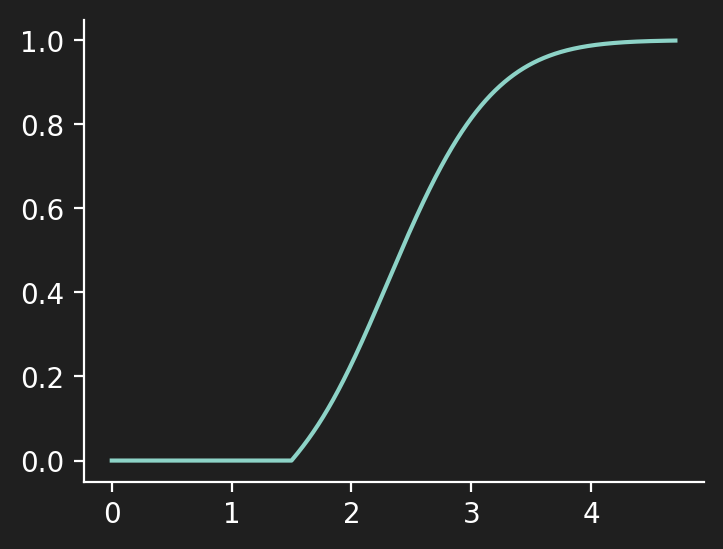

In [ ]:
param_graph.update_parameterized_weights([1, 0, 0])

ctx = param_graph.distribution_context()
cdfs = []
times = []

while ctx.time() < 1.5:
    cdfs.append(ctx.cdf())
    times.append(ctx.time())
    ctx.step()

#param_graph.update_parameterized_weights([1, 1, 1])

# at time 1.5, the flooding starts!
while ctx.cdf() < 0.999:
    cdfs.append(ctx.cdf())
    times.append(ctx.time())
    param_graph.update_parameterized_weights(
        [1,
        ctx.time() - 1.5, 
        2 * ctx.time() - 1.5
        ]
    )
    ctx.step()

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(times, cdfs)
sns.despine()

If we pick a time far into the future, we can integrate under it to find the expectation. This means that we can scale by a reward, and thereby find the marginal expectation.

Summing over accumulated visiting time (with reward):

In [ ]:
np.sum(graph.accumulated_visiting_time(10)*graph.states()[:,1])

np.float64(0.09438775509887067)

The first moment (expectation) (with reward):

In [ ]:
graph.expectation(graph.states()[:,1])

0.09438775510204081

But if the time is *not* far into the future, we get the expectation up to a certain point in time.

Expectation (rewarded) when truncating at 0.05 time:          

In [ ]:
np.sum(graph.accumulated_visiting_time(0.05)*graph.states()[:,1])

np.float64(0.0011713234985744549)

Untruncated expectation:

In [ ]:
graph.expectation(graph.states()[:,1])

0.09438775510204081

Expectation (rewarded) when *starting* at 0.05 time:          

## Modelling epochs in state space

## Laplace transform

The Laplace transform is a fundamental tool for analyzing continuous phase-type distributions. For a random variable T with probability density function f(t), the Laplace transform is defined as L(s) = E[e^(-sT)] = ∫₀^∞ e^(-st) f(t) dt. For phase-type distributions represented as absorbing Markov chains, the Laplace transform has an elegant matrix form that can be computed efficiently from the graph structure.

The Laplace transform is particularly useful because it provides an alternative characterization of the distribution that often simplifies analytical calculations. Moments can be recovered by differentiating the Laplace transform: the n-th moment is E[T^n] = (-1)^n (d^n L/ds^n)|_{s=0}. The Laplace transform also plays a crucial role in analyzing time-inhomogeneous processes and in computing convolutions of distributions.

In our rabbit model, the Laplace transform captures the moment generating function of the time until all rabbits have died. Let's compute it and verify that we can recover moments by differentiation.

In [ ]:
# Compute Laplace transform for several values of s
s_values = np.array([0.1, 0.5, 1.0, 2.0, 5.0, 10.0])
laplace_values = graph.laplace_transform(s_values)

print("Laplace transform L(s) = E[e^(-sT)]:")
for s, L_s in zip(s_values, laplace_values):
    print(f"  L({s:4.1f}) = {L_s:.6f}")

# Verify that L(0) = 1 (certain event)
L_0 = graph.laplace_transform(np.array([0.0]))[0]
print(f"\nVerification: L(0) = {L_0:.10f} (should be 1.0)")

# Verify relationship to moments using numerical differentiation
# E[T] = -L'(0), so we approximate with finite differences
h = 1e-6
L_h = graph.laplace_transform(np.array([h]))[0]
L_0 = graph.laplace_transform(np.array([0.0]))[0]
numerical_expectation = -(L_h - L_0) / h
analytical_expectation = graph.expectation()

print(f"\nExpectation from Laplace derivative: {numerical_expectation:.6f}")
print(f"Expectation from direct computation: {analytical_expectation:.6f}")
print(f"Relative error: {abs(numerical_expectation - analytical_expectation)/analytical_expectation * 100:.4f}%")

## Joint probability

Phase-type distributions can be extended to model joint probabilities of multiple random variables. This is particularly important in applications like population genetics, where we might be interested in the joint distribution of coalescence times for multiple lineages, or in reliability theory, where we might want the joint distribution of failure times for multiple components. The library provides tools for constructing and analyzing such joint distributions through the concept of multi-dimensional phase-type distributions.

The key idea is that we can embed multiple independent or dependent processes into a single state space, where the state vector encodes the progress of all processes simultaneously. Transitions in this joint state space then correspond to events in any of the individual processes. By carefully constructing the edge weights and using reward transformations, we can extract marginal distributions, conditional distributions, and joint distribution functions.

In our rabbit model, we might be interested in the joint distribution of two quantities: the time until the left island is depleted (either by jumping or flooding) and the time until the right island is depleted. These two times are not independent—they are coupled through the rabbits jumping between islands. Let's construct a model that tracks both times simultaneously.

In [70]:
# Construct a rabbit model that tracks time to depletion for each island separately
def construct_joint_time_model(nr_rabbits, flood_left, flood_right):
    """
    Construct a model tracking joint distribution of depletion times.
    State: [rabbits_left, rabbits_right, left_depleted, right_depleted]
    """
    graph = Graph(state_length=4)

    initial_state = [nr_rabbits, 0, 0, 0]  # Start with all rabbits on left
    graph.starting_vertex().add_edge(graph.find_or_create_vertex(initial_state), 1)

    index = 1
    while index < graph.vertices_length():
        vertex = graph.vertex_at(index)
        state = list(vertex.state())

        # If left island has rabbits and not yet depleted
        if state[0] > 0 and state[2] == 0:
            # Jump to right
            child_state = [state[0] - 1, state[1] + 1, state[2], state[3]]
            if child_state[0] == 0:
                child_state[2] = 1  # Mark left as depleted
            vertex.add_edge(graph.find_or_create_vertex(child_state), weight=1)

            # Left flooding
            child_state = [0, state[1], 1, state[3]]  # All left rabbits die, mark depleted
            vertex.add_edge(graph.find_or_create_vertex(child_state), weight=flood_left)

        # If right island has rabbits and not yet depleted
        if state[1] > 0 and state[3] == 0:
            # Jump to left
            child_state = [state[0] + 1, state[1] - 1, state[2], state[3]]
            if child_state[1] == 0:
                child_state[3] = 1  # Mark right as depleted
            vertex.add_edge(graph.find_or_create_vertex(child_state), weight=1)

            # Right flooding
            child_state = [state[0], 0, state[2], 1]  # All right rabbits die, mark depleted
            vertex.add_edge(graph.find_or_create_vertex(child_state), weight=flood_right)

        index += 1

    return graph

# Create the joint model
joint_graph = construct_joint_time_model(3, 2.0, 4.0)
print(f"Created joint model with {joint_graph.vertices_length()} states")
print(f"\nFirst few states (rabbits_left, rabbits_right, left_depleted, right_depleted):")
for i in range(min(10, joint_graph.vertices_length())):
    print(f"  State {i}: {joint_graph.vertex_at(i).state()}")

Created joint model with 24 states

First few states (rabbits_left, rabbits_right, left_depleted, right_depleted):
  State 0: [0 0 0 0]
  State 1: [3 0 0 0]
  State 2: [2 1 0 0]
  State 3: [0 0 1 0]
  State 4: [1 2 0 0]
  State 5: [0 1 1 0]
  State 6: [3 0 0 1]
  State 7: [2 0 0 1]
  State 8: [0 3 1 0]
  State 9: [0 2 1 0]


Now we can use rewards to extract information about the joint distribution. By defining rewards that are non-zero only until each island is depleted, we can compute the marginal time until depletion for each island. By looking at the joint accumulated rewards, we can explore the correlation between these depletion times.

In [71]:
# Define rewards: earn reward while island is not depleted
states = joint_graph.states()

# Reward 1: time spent before left depletion (left_depleted == 0)
reward_before_left_depletion = (states[:, 2] == 0).astype(float)

# Reward 2: time spent before right depletion (right_depleted == 0)
reward_before_right_depletion = (states[:, 3] == 0).astype(float)

# Compute expectations
E_time_to_left_depletion = joint_graph.expectation(reward_before_left_depletion)
E_time_to_right_depletion = joint_graph.expectation(reward_before_right_depletion)

print(f"Expected time until left island depleted: {E_time_to_left_depletion:.4f}")
print(f"Expected time until right island depleted: {E_time_to_right_depletion:.4f}")

# Compute covariance between the two times
cov = joint_graph.covariance(reward_before_left_depletion, reward_before_right_depletion)
var_left = joint_graph.variance(reward_before_left_depletion)
var_right = joint_graph.variance(reward_before_right_depletion)
correlation = cov / np.sqrt(var_left * var_right)

print(f"\nCovariance between depletion times: {cov:.6f}")
print(f"Correlation: {correlation:.4f}")
print("\nThe positive correlation indicates that when the left island takes longer to deplete,")
print("the right island also tends to take longer (rabbits jumping back and forth prolongs both)")

Expected time until left island depleted: 0.4836
Expected time until right island depleted: 0.4017

Covariance between depletion times: 0.131722
Correlation: 0.7704

The positive correlation indicates that when the left island takes longer to deplete,
the right island also tends to take longer (rabbits jumping back and forth prolongs both)


INFO: building reward compute graph...


This framework for joint probabilities extends naturally to more complex scenarios. We can model multiple dependent processes, extract conditional distributions, and analyze the dependencies between different random variables in our model. The key is careful state space construction that encodes all relevant information, combined with judicious use of rewards to extract the quantities of interest. In population genetics applications, this approach is used to model the joint distribution of coalescence times across multiple loci or populations, capturing the complex dependencies induced by recombination and migration.

We can increase granularity for better performance:

In [72]:
np.sum(graph.accumulated_visiting_time(0.05, granularity=1000000)*graph.states()[:,1])

np.float64(0.0011138317897953385)

# Building the state space in C

Very very large models can be take a long time to construct. So if you have deloped a model that you need to construct repeatedly, the library allow you to implement the state construction as a stand-alone C/C++ extension available as python module. 

The C code building the state space for the rabit model looks like this:

```{c}
ptdalgorithms::Graph build(int starting_rabbits, float flooding_left, float flooding_right) {

    size_t state_size = 2;
    struct ptd_graph *graph = ptd_graph_create(state_size);
    struct ptd_avl_tree *avl_tree = ptd_avl_tree_create(state_size);
    int *initial_state = (int*)calloc(graph->state_length, sizeof(*initial_state));
    int *child_state = (int*)calloc(graph->state_length, sizeof(*initial_state));
    initial_state[0] = starting_rabbits;
    ptd_graph_add_edge(
            graph->starting_vertex,
            ptd_find_or_create_vertex(graph, avl_tree, initial_state),
            1
    );
    for (size_t k = 1; k < graph->vertices_length; k++) {
        struct ptd_vertex *vertex = graph->vertices[k];
        int *state = vertex->state;
        if (state[0] > 0) {
            memcpy(child_state, vertex->state, graph->state_length * sizeof(int));
            child_state[0] -= 1;
            child_state[1] += 1;

            ptd_graph_add_edge(
                    vertex,
                    ptd_find_or_create_vertex(graph, avl_tree, child_state),
                    1
            );
            memcpy(child_state, vertex->state, graph->state_length * sizeof(int));
            child_state[0] = 0;
            ptd_graph_add_edge(
                    vertex,
                    ptd_find_or_create_vertex(graph, avl_tree, child_state),
                    flooding_left
            );
        }
        if (state[1] > 0) {
            memcpy(child_state, vertex->state, graph->state_length * sizeof(int));
            child_state[1] -= 1;
            child_state[0] += 1;
            ptd_graph_add_edge(
                    vertex,
                    ptd_find_or_create_vertex(graph, avl_tree, child_state),
                    1
            );
            memcpy(child_state, vertex->state, graph->state_length * sizeof(int));
            child_state[1] = 0;
            ptd_graph_add_edge(
                    vertex,
                    ptd_find_or_create_vertex(graph, avl_tree, child_state),
                    flooding_right
            );
        }
    }
    free(child_state);
    ptdalgorithms::Graph *result = new ptdalgorithms::Graph(graph, avl_tree);
    return *result;
}

To access the function from python, you need to put it a separate file (`rabbit_state_space.cpp`) with the header and footer shown below:

```{c}
#include <pybind11/pybind11.h>
#include <ptdalgorithms.h>
#include "stdint.h"
#include "stdlib.h"

namespace py = pybind11;
using namespace pybind11::literals;
/*******************************************/


/* Your build function goes here */


/********************************************/
PYBIND11_MODULE(rabbit_state_space, m) {     /* <- NB: the model name must match the file name */
     m.def("build", &build);
}

/*
<%
setup_pybind11(cfg)
%>
*/
```

You can see the complete code in [rabbit_state_space.cpp](rabbit_state_space.cpp).

Then all you need to do is install cppimport

    pixi add cppimport

or
    
    pip install cppimport

and then run this code to import your build function.

```python
# import ptdalgorithms
import cppimport.import_hook
import rabbit_state_space # this will pause for a moment to compile the module
```

Then you can use it to construct your graph like this:

```python
graph = ptd.Graph(rabbit_state_space.build(2, 2, 4))
graph.plot()
```

# Inference

## Bayesian Inference with SVGD (Stein Variational Gradient Descent)

Having explored how to construct models, compute their properties, evaluate them efficiently, and scale computations across distributed clusters, we now turn to a fundamental question: given observed data, how do we estimate the parameters of our model? This is the domain of statistical inference. In a Bayesian framework, we seek not just point estimates but entire posterior distributions over parameters, quantifying our uncertainty about parameter values given the data we have observed.

Traditional Markov Chain Monte Carlo (MCMC) methods like Metropolis-Hastings and Hamiltonian Monte Carlo have been the workhorses of Bayesian inference for decades. However, these methods face challenges with high-dimensional parameter spaces, complex posterior geometries, and the need for many sequential samples to achieve convergence. Stein Variational Gradient Descent (SVGD) offers a compelling alternative. Instead of generating samples sequentially through a Markov chain, SVGD represents the posterior with a set of particles (parameter vectors) and updates these particles iteratively to move them toward the posterior distribution. The method combines ideas from optimization, kernel methods, and functional analysis to create a deterministic algorithm that is highly parallelizable and works well in high dimensions.

The key insight of SVGD is to treat inference as an optimization problem in the space of probability distributions. We start with an initial set of particles (typically drawn from the prior or from a simple distribution) and iteratively transport these particles toward the posterior using gradient information. Each particle interacts with all other particles through a kernel function, with the interaction strength depending on the distance between particles. This interaction ensures that particles spread out to cover the posterior distribution rather than collapsing to a single mode. The updates use gradients of the log-likelihood and log-prior, which we can compute efficiently using JAX's automatic differentiation.

For our rabbit model, imagine we have observed data: the time until all rabbits died. Based on this observation, we want to estimate the three parameters of our model—jump rate, left flooding rate, and right flooding rate—along with quantifying our uncertainty about these parameters. We will set up a likelihood function, specify a prior distribution, and use SVGD to approximate the posterior distribution with a set of particles. This workflow showcases the entire pipeline: model construction, JAX integration, gradient-based inference, and (optionally) distributed computing.
Now we need to define our inference problem in terms of a log-posterior function. According to Bayes' theorem, the posterior is proportional to the likelihood times the prior: p(θ|data) ∝ p(data|θ) × p(θ). Taking logarithms gives us log p(θ|data) = log p(data|θ) + log p(θ) + constant. The SVGD algorithm requires us to provide a function that computes this log-posterior (up to an additive constant, which doesn't affect gradients).

For the likelihood, we use the probability density function of our phase-type distribution evaluated at the observed times. For the prior, we will use independent log-normal distributions for each parameter, reflecting our prior belief that parameters are positive with uncertainty spanning orders of magnitude.

In [ ]:
# graph = 
# 

The SVGD particles now represent our posterior distribution. Each particle is a plausible set of parameter values given the observed data, and the collection of particles approximates the full posterior. We can use these particles to compute posterior summaries (means, quantiles, credible intervals), make predictions, or perform model checking. The spread of the particles reflects our uncertainty—parameters with wide spread are less constrained by the data, while parameters with narrow spread are well-determined.

This inference workflow showcases the full power of the ptdalgorithms ecosystem. We constructed a complex stochastic model using graph-based state space representation. We parameterized it for efficient exploration of parameter space. We performed symbolic Gaussian elimination to enable ultra-fast repeated evaluation. We integrated with JAX for automatic differentiation and JIT compilation. We implemented a gradient-based inference algorithm (SVGD) that can be parallelized across devices and nodes. And we can scale this entire workflow to much larger problems—more complex models, more observations, more particles—by leveraging distributed computing.

For production inference runs, you would typically use more particles (100-1000), run for more iterations (1000-10000), use adaptive step sizes, monitor convergence diagnostics, and leverage the distributed computing infrastructure we described earlier to parallelize across many nodes. The combination of symbolic elimination (100× faster evaluation), distributed computing (100× more parallel evaluations), and gradient-based inference (100× fewer iterations than MCMC) can easily provide five or six orders of magnitude of speedup compared to naive approaches, transforming intractable problems into routine computations.

Modern computational infrastructure offers substantial computing power not just through faster processors, but through massive parallelism across multiple machines. A typical high-performance computing (HPC) cluster might have dozens to hundreds of compute nodes, each with dozens of CPU cores, representing thousands of processor cores working in parallel. For computationally intensive tasks like Bayesian inference, where we need to evaluate a complex model millions of times, this parallel computing power is transformative. What might take days on a single machine can complete in hours or minutes when distributed across a cluster.

The ptdalgorithms library is designed from the ground up to leverage this distributed computing infrastructure. Through tight integration with JAX's distributed computing capabilities and support for SLURM (Simple Linux Utility for Resource Management), the standard job scheduler on HPC clusters, the library makes it straightforward to scale from running on your laptop to running on hundreds of nodes. The key insight is that many inference algorithms—particularly particle-based methods like Stein Variational Gradient Descent (SVGD)—are naturally parallel. Each particle can be evaluated independently, and gradients can be computed in parallel across all particles. With the right infrastructure, we can distribute these particles across many machines and aggregate results efficiently.

This section demonstrates how to set up and run distributed computations with ptdalgorithms. We will see how the library automatically detects whether it is running on a SLURM cluster, how it coordinates multiple processes across different nodes, and how JAX distributes computations across available resources. We will work with our rabbit model, showing how the combination of symbolic elimination (for fast per-particle evaluation) and distributed computing (for parallel particle evaluation) enables inference at scales that would be impossible on a single machine.

The workflow has three main components: (1) initialization, where we detect the distributed environment and set up JAX for multi-node computation; (2) model setup, where we construct our parameterized model and perform symbolic elimination; and (3) distributed evaluation, where we leverage JAX's `pmap` (parallel map) to evaluate the model across all available devices in parallel. Let's see each component in detail.

## Distributed Computing

In [ ]:

# code here


[INFO] Not running under SLURM - using single-node setup
[INFO] Configured JAX for 1 CPU devices
[INFO] JAX x64 precision enabled
[INFO] Single-node setup - no distributed initialization needed
[INFO] 
Distributed Configuration:
  Job ID: N/A
  Process: 0/1
  Coordinator: localhost:12345 (this node)
  Local devices: 1
  Global devices: 1
  Platform: cpu


Distributed computing initialized:


AttributeError: 'DistributedConfig' object has no attribute 'global_rank'